<a href="https://colab.research.google.com/github/KarelZe/adv-ml/blob/main/AML_Bonus_Model_Only_res_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebooks for testing models only


In [28]:
%%capture
!pip install -U imbalanced-learn
!pip install -U yellowbrick

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, LogisticRegression, lasso_path
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    matthews_corrcoef,
    plot_confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from yellowbrick.classifier.rocauc import roc_auc

# apply some custom styling to charts
sns.set_theme(style="whitegrid", palette="rocket", font_scale=1.1, color_codes=True)
cmap = sns.cm.rocket

import matplotlib.pyplot as plt
%matplotlib inline

# increase the number of rows displayed to fully display all (transposed) features.
pd.options.display.max_rows = 1000


## Loading the data

In [30]:
drive.mount("/content/drive")

# load proprocessed data
X_train = pd.read_pickle("/content/drive/My Drive/AdvancedML/X_train.pkl")
y_train = pd.read_pickle("/content/drive/My Drive/AdvancedML/y_train.pkl")

X_test = pd.read_pickle("/content/drive/My Drive/AdvancedML/X_test.pkl")
y_test = pd.read_pickle("/content/drive/My Drive/AdvancedML/y_test.pkl")    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Task 3: Use logistic regression (in-sample) for default prediction. Interpret your results for logistic regression. (20 points)

To compare the models in the end a DataFrame storing the performance metrics is created.

In [31]:
performance = pd.DataFrame()

## Task 4: Compare logistic regression, classification tree, random forest, bagging, support vector machine (with two kernel functions), and neural network for default prediction based on the out-of-sample performance measures (at least three different measures). (35 points)

### Preliminary

For model evaluation the same performance metrics are calculated. In contrast to the in-sampling method for Logistic Regression an out-of-sample approach is used by using separated data for training and testing.

In [32]:
def print_results(model, performance):
    y_pred_model = model.predict(X_test)

    print(classification_report(y_test, y_pred_model))

    fig, ax = plt.subplots(figsize=(16, 9))
    disp = plot_confusion_matrix(model, X_test, y_test, display_labels=['Non-Default', 'Default'], ax=ax)
    plt.title(f"Confusion matrix for {model.__class__.__name__}")
    disp.ax_.grid(False)
    plt.show()

    print(f"Accuracy: {accuracy_score(y_test, y_pred_model):.2f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_model):.2f}")
    print(f"MCC: {matthews_corrcoef(y_test, y_pred_model):.2f}")
    print()
    print(f"Params: {model.get_params()}")

    performance_metrics = pd.DataFrame({'Accuracy': accuracy_score(y_test, y_pred_model),
                                        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_model),
                                        'Matthews Corrcoef': matthews_corrcoef(y_test, y_pred_model)},
                                       index=[f"{model.__class__.__name__}"])
    performance = performance.append(performance_metrics)
    return performance

In [33]:
# based on https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html
def print_performance_measures(model):
    # Instantiate the visualizer with the classification model
    plt.figure(figsize=(9, 9))
    # FIXME: binary flag not working. Figure out why.
    roc_auc(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=["Default", "Non-Default"], binary=True)
    plt.show()

### Decision Tree

In [34]:
# max_depth = [2, 6, 10, 14...]
#min_depth = 2
#step_size = 4
#step_count = 2 ** 4
#max_depth = min_depth + np.arange(step_count) * step_size

# perform grid search
#param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': max_depth}
#grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid, refit=True, verbose=0 ,n_jobs=-1)
#grid_dt.fit(X_train, y_train)

# choose best model
#grid_dt_optimized = grid_dt.best_estimator_

# print confusion 
#performance_metrics = print_results(grid_dt_optimized, performance)

#print_performance_measures(grid_dt_optimized)

In [35]:
performance

""


### Plot Decision Tree

In [36]:
#fig, ax = plt.subplots(figsize=(16, 9))
#tree.plot_tree(grid_dt_optimized, feature_names=X_train.columns, proportion=True, max_depth=2);

### Plot feature importances of Decision Tree

In [37]:
def print_feature_importance(feature_importance):
    """
    function to create a paretto plot with the gini importance of features.
    """
    feature_importance.sort_values(ascending=False, inplace=True, by=0)

    feature_importance['pareto'] = 100 * feature_importance[0].cumsum() / feature_importance[0].sum()
    feature_importance.rename(columns={0: 'importance'}, inplace=True)

    fig, axes = plt.subplots(figsize=(16, 9))
    ax1 = feature_importance.plot(use_index=True, y='importance', kind='bar', ax=axes, color=cmap(150))
    ax2 = feature_importance.plot(use_index=True, y='pareto', marker='D', color=cmap(7), kind='line', ax=axes,
                                  secondary_y=True)
    ax2.set_ylim([0, 110])
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.xticks(rotation=45)
    plt.title(f"feature importances given by '.feature_importances_' for {grid_dt_optimized.__class__.__name__}")
    plt.show()


 
#importance = grid_dt_optimized.feature_importances_
#feature_importance = pd.DataFrame(importance, X_train.columns)

#print_feature_importance(feature_importance)

### Random Forest

              precision    recall  f1-score   support

       False       0.97      0.94      0.95     29482
        True       0.67      0.81      0.73      4428

    accuracy                           0.92     33910
   macro avg       0.82      0.88      0.84     33910
weighted avg       0.93      0.92      0.93     33910



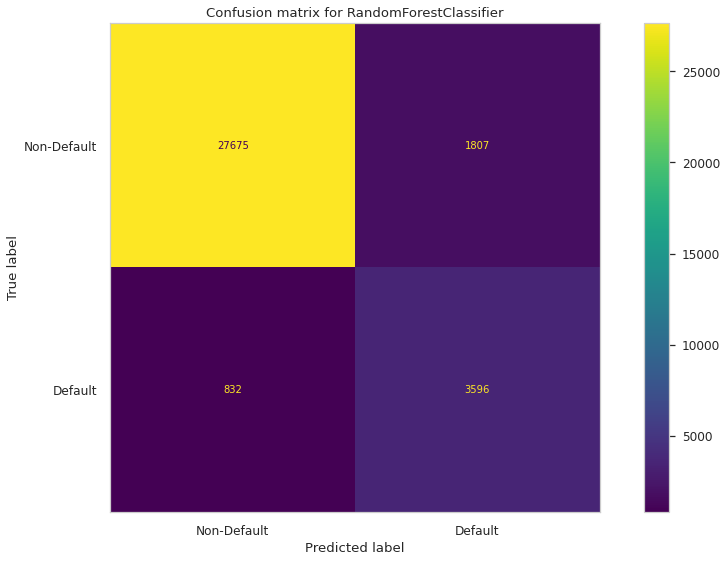

Accuracy: 0.92
Balanced Accuracy: 0.88
MCC: 0.69

Params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 18, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


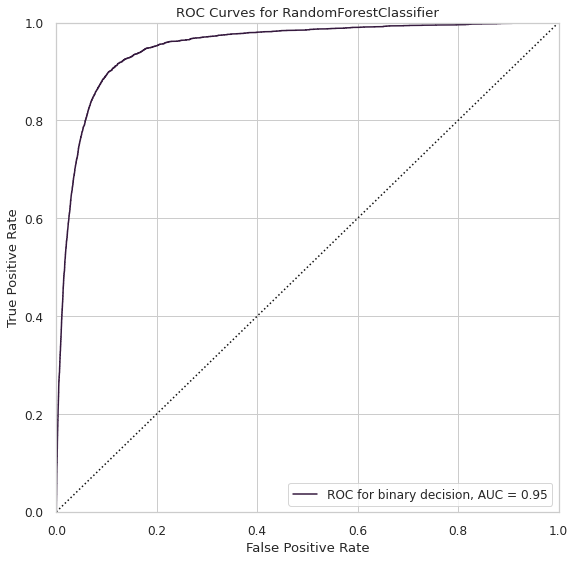

In [38]:
# [2, 6, 10, 14...]
max_depth = np.arange(2, 22, 4)
# [5, 10, 25, 50, 100, 150]
n_estimators = [5, 10, 25, 50, 100, 150]

# perform grid search
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': max_depth, 'n_estimators': n_estimators,
              'max_features': ['auto', 'sqrt', 'log2']}
grid_rf = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid, refit=True, verbose=0, n_jobs=-1)
grid_rf.fit(X_train, y_train.values.ravel())

# choose best model
grid_rf_optimized = grid_rf.best_estimator_

# print confusion 
performance = print_results(grid_rf_optimized, performance)

print_performance_measures(grid_rf_optimized)

In [39]:
performance

,Accuracy,Balanced Accuracy,Matthews Corrcoef
RandomForestClassifier,0.922176,0.875407,0.691227


### Bagging

              precision    recall  f1-score   support

       False       0.94      0.85      0.89     29482
        True       0.38      0.62      0.48      4428

    accuracy                           0.82     33910
   macro avg       0.66      0.74      0.68     33910
weighted avg       0.87      0.82      0.84     33910



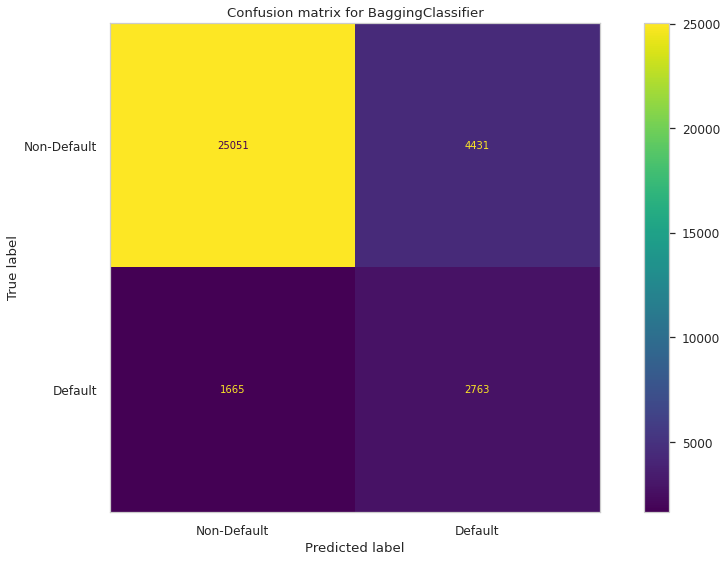

Accuracy: 0.82
Balanced Accuracy: 0.74
MCC: 0.39

Params: {'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 3, 'max_samples': 4, 'n_estimators': 150, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


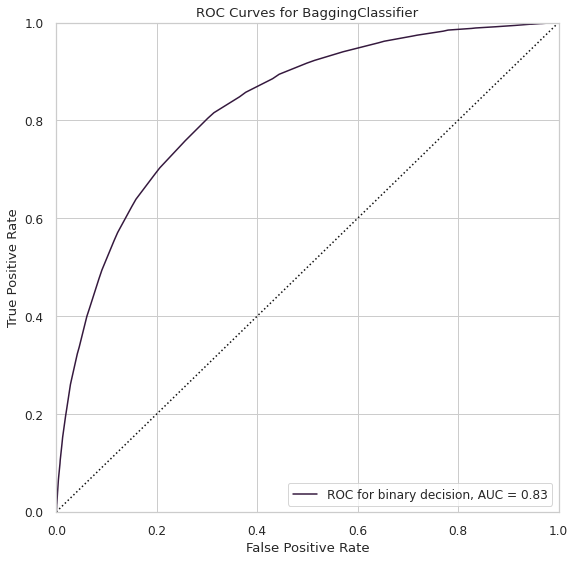

In [40]:
# TODO: Validate results with larger dataset

# perform grid search
param_grid = {'n_estimators': [5, 10, 25, 50, 100, 150], 'max_samples': [1, 2, 3, 4, 5], 'max_features': [1, 2, 3]}
#'base_estimator': ['SVC()', 'DecisionTreeClassifier()', 'RandomForestClassifier()'], 
grid_bag = GridSearchCV(BaggingClassifier(n_jobs=-1), param_grid, refit=True, verbose=0, n_jobs=-1)
grid_bag.fit(X_train, y_train.values.ravel())

# choose best model
grid_bag_optimized = grid_bag.best_estimator_

# print confusion 
performance = print_results(grid_bag_optimized, performance)
print_performance_measures(grid_bag_optimized)

In [ ]:
param_grid = {
    'base_estimator__max_depth' : [1, 2, 3, 4, 5],
    'max_samples' : [0.05, 0.1, 0.2, 0.5]
}

grid_bag = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(),
                                     n_estimators = 100, max_features = 0.5, n_jobs=-1),
                   param_grid, n_jobs=-1)
grid_bag.fit(X_train, y_train.values.ravel())


# choose best model
grid_bag_optimized = grid_bag.best_estimator_

# print confusion 
performance = print_results(grid_bag_optimized, performance)
print_performance_measures(grid_bag_optimized)

In [ ]:
min_depth = 2
step_size = 4
step_count = 2 ** 4
max_depth = min_depth + np.arange(step_count) * step_size

param_grid = {
    'base_estimator__max_depth' : max_depth,
    'base_estimator__criterion': ['gini', 'entropy'],
    'max_samples' : [0.05, 0.1, 0.2, 0.5]
}

grid_bag = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(),
                                     n_estimators = 100, max_features = 0.5, n_jobs=-1),
                   param_grid, n_jobs=-1)
grid_bag.fit(X_train, y_train.values.ravel())


# choose best model
grid_bag_optimized = grid_bag.best_estimator_

# print confusion 
performance = print_results(grid_bag_optimized, performance)
print_performance_measures(grid_bag_optimized)

In [ ]:
performance

### Support Vector Machine

Next, we look at SVM with two different kernels. Namely, a rfb kernel and linear kernel.

In [ ]:
min_c = 0.1
step_size = 0.1
step_count = 15

C = min_c + np.arange(step_count) * step_size

param_grid = {'C': C, 'gamma': [1, 0.1], 'kernel': ['rbf', 'linear']}
grid_svm = GridSearchCV(SVC(), param_grid, refit=True, verbose=0, n_jobs=-1)
grid_svm.fit(X_train, y_train.values.ravel())

# choose best model
grid_svm_optimized = grid_svm.best_estimator_

# print confusion 
performance = print_results(grid_svm_optimized, performance)

print_performance_measures(grid_svm_optimized)

In [ ]:
performance

### Neural Network 

In [ ]:
param_grid = {'activation': ['logistic', 'relu'], 'learning_rate': ['constant', 'invscaling'],
              'hidden_layer_sizes': [(100, 1), (100, 2)], 'early_stopping': True}
grid_nn = GridSearchCV(MLPClassifier(), param_grid, refit=True, verbose=0, n_jobs=-1)
grid_nn.fit(X_train, y_train.values.ravel())

# choose best model
grid_nn_optimized = grid_nn.best_estimator_

# print confusion 
performance = print_results(grid_nn_optimized, performance)

print_performance_measures(grid_nn_optimized)

In [ ]:
performance

## Voting Classifier

In [ ]:
# TODO: Optional. Combine the best Classifiers e. g. SVM and RF
model_voting = VotingClassifier(estimators=[('SVM', grid_svm_optimized), ('Random Forest', model_rf_optimized)],
                                   voting='hard', n_jobs=-1)
model_voting.fit(X_train, y_train.values.ravel())

# print confusion matrix
performance = print_result(model_voting, performance)

print_performance_measures(model_voting)

## Stacking Classifier

In [ ]:
# TODO: insert Code
estimators = [('Neural Net', grid_nn_optimized), ('Random Forest', grid_rf_optimized)]
model_stacked = StackingClassifier(estimators=estimators,
                                   final_estimator=LogisticRegression(max_iter=200, penalty='l1', solver='liblinear'), n_jobs=-1)

model_stacked.fit(X_train, y_train.values.ravel())

performance = print_results(model_stacked, performance)

print_performance_measures(model_stacked)

Bringing it all together....

##Task 5: Use LASSO for variable selection and explain results. (15 points)

In Task 5 we use a LASSO model for variable selection. First we run a grid search to find a suitable value for the penalty weight $\alpha$. We use the metric Area under the curve (AUC) is the criteria for model selection.

In [ ]:
# TODO: LASSO for classification -> < 0.5 / > 0.5?
# TODO: Discussion suitable for classifcation / automatic feature selection (pros and cons) 
# TODO: Move to end

# use LassoCV to find the optimal alpha
lasso = LassoCV(cv=5, random_state=0, max_iter=5000).fit(X, y)
model = SelectFromModel(lasso, prefit=True)
X_new = model.transform(X)
print('X shape: ', X_new.shape)
print('lasso_coef: ', lasso.coef_)
print('lasso_intercept: ', lasso.intercept_)
print('lasso_alpha: ', lasso.alpha_)
lasso_alpha = lasso.alpha_

Next we look at coefficient of the optimized alpha....

In [ ]:
coef_importance = pd.DataFrame(lasso.coef_, index=X.columns)
coef_importance.rename(columns={0: 'importance'}, inplace=True)
coef_importance = coef_importance.iloc[(-np.abs(coef_importance['importance'].values)).argsort()]

fig, axes = plt.subplots(figsize=(16, 9))
ax1 = coef_importance.plot(use_index=True, y='importance', kind='bar', ax=axes, color=cmap(150), legend=False)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
plt.xticks(rotation=45)
plt.title(f"abs. feature importances given by '.coef' for {model.__class__.__name__}")
plt.show()

And more general for varying alpha....

In [ ]:
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, n_alphas=20, fit_intercept=False)

In [ ]:
neg_log_alphas_lasso = -np.log10(alphas_lasso)

# create df with coefs and their importance
df_test = pd.DataFrame(coefs_lasso[0], index=X.columns)
df_test.columns = neg_log_alphas_lasso

# TODO: logscale y axis

# plot
plt.figure(figsize=(20, 20))
g = sns.lineplot(data=df_test.T)
plt.xlabel('-log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso paths')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.show(g);

In [ ]:
performance